In [1]:
import os
import csv
import scipy
from importlib import reload
import numpy as np
import pandas as pd
from anndata import AnnData
import scanpy as sc
import scvelo as scv
import sklearn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba.typed import List
import sys
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))
display(HTML("<style>.container { width:90% !important; }</style>"))
import random

from scipy.stats import qmc

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.append("../src/multivelo")
from dynamical_chrom_func import *
import multivelo as mv

In [3]:
# the folder from which to read the original
# rate parameters from

# figure data:
read_folder = "./data/rates/fig_rates_train"

# validation data:
# You will need to supply your own validation data in order to run this code!
# read folder =

## Set User-Defined Simulation Parameters

In [4]:
# name of the folder we save the simulated data to

save_folder = "./data/simulated_data/dir2_m1"

In [5]:
# number of cells to simulate per gene
n = 750

# the direction of the gene we're simulating
# 0 = complete genes
# 1 = activation genes
# 2 = repression genes
dire = 2

# the list of appropriate gene models to simulate
models = [1]

# the factor to multiply the noise for c/u/s by
factor = 1
# factor = 0

In [6]:
# Multiply the number of genes in the data by at
# least this value (extra will be multiplied for
# special cases)
# n_gene_multiply = 0
n_gene_multiply = 5

# The fractional "radius" within which we can generate new values.
# When generating new simulated genes, we either add or 
# subtract a random value to the rate parameters that
# falls within the range of [0, radius * original parameter).
radius = 0.1

In [7]:
# some gene values are much larger than the majority,
# but aren't large enough to be discarded as outliers.
# When this happens, these two variables help govern how
# to generate extra data around these points

# Governs how much we want the gene multiplier
# to grow for larger parameter values
multiplier = 10
# multiplier = 0

# Governs how much we
# want the radius to increase
# for these larger values
radius_scale = 1

In [8]:
# set the random seed for simulation
wildcard = 100

np.random.seed(int(n_gene_multiply * (dire + 1) + wildcard + multiplier))

In [9]:
ac_orig = np.loadtxt(read_folder+"/alpha_c.txt")
a_orig = np.loadtxt(read_folder+"/alpha.txt")
b_orig = np.loadtxt(read_folder+"/beta.txt")
g_orig = np.loadtxt(read_folder+"/gamma.txt")

big_a_orig = 10
big_ac_orig = 0.1
big_b_orig = 1
big_g_orig = 1.5

print(big_a_orig)

ac_too_big = 0.2
a_too_big = 100
b_too_big = 1.75
g_too_big = 2.2

# m_orig = np.loadtxt(read_folder+"/model_list.txt")

ac_sorted = np.sort(ac_orig)
a_sorted = np.sort(a_orig)
b_sorted = np.sort(b_orig)
g_sorted = np.sort(g_orig)

orig_n_gene = len(ac_orig)

10


In [10]:
def add_new_param(orig, i, param_array, radius):
    
    # randomly add a value to the original data
    # that's falls in the range [original value - radius, original value + radius)
    # choice = np.random.choice([0,1])
    new_val = orig[i] - radius + (2 * radius * np.random.random())

    # if something goes wrong and the new value is less than zero,
    # then just return the original value
    if new_val < 0:
        new_val = orig[i]

    # add the new value to the array of rate parameters
    param_array.append(new_val)

## Generate Gene Rate Parameters

In [11]:
alpha_c = []
alpha = []
beta = []
gamma = []

In [12]:
# iterate through the rate parameters of all the original genes
for i in range(orig_n_gene):

    # if any of the data points are extreme outliers, skip this iteration
    if ac_orig[i] > ac_too_big or a_orig[i] > a_too_big or b_orig[i] > b_too_big or b_orig[i] > b_too_big:
        continue

    # store the original radius and
    # gene multiplier values
    ac_radius = radius
    a_radius = radius
    b_radius = radius
    g_radius = radius
    cur_gene_multiply = n_gene_multiply

    # find the difference between the rate parameter values
    # we're looking at and the "big" boundary values
    ac_diff = ac_orig[i] - big_ac_orig
    a_diff = a_orig[i] - big_a_orig
    b_diff = b_orig[i] - big_b_orig
    g_diff = g_orig[i] - big_g_orig

    # check to see if the rate parameter is sufficiently big
    # enough to increase the number of simulated genes around it
    big_val = (ac_diff > 0) or (a_diff > 0) or (b_diff > 0) or (g_diff > 0)

    # if the parameter is sufficiently big,
    # increase the gene multiplier value
    if big_val:
        cur_gene_multiply *= multiplier

    # Add even more gene multiplication
    # if multiple big parameter values are stacking
    # (radius expansions stack as well)
    if ac_diff > 0:
        cur_gene_multiply += multiplier * 2
        ac_radius *= radius_scale

    if a_diff > 0:
        cur_gene_multiply += multiplier
        a_radius *= radius_scale

    if b_diff > 0:
        cur_gene_multiply += multiplier
        b_radius *= radius_scale

    if g_diff > 0:
        cur_gene_multiply += multiplier
        g_radius *= radius_scale

    # add the original values to the data no matter what
    alpha_c.append(ac_orig[i])
    alpha.append(a_orig[i])
    beta.append(b_orig[i])
    gamma.append(g_orig[i])

    # generate new data points as many times
    # as we've determined we need
    for j in range(int(cur_gene_multiply)):
        
        add_new_param(ac_orig, i, alpha_c, ac_radius)
        add_new_param(a_orig, i, alpha, a_radius)
        add_new_param(b_orig, i, beta, b_radius)
        add_new_param(g_orig, i, gamma, g_radius)

In [13]:
# assemble the final data
mvln = np.array([alpha_c, alpha, beta, gamma]).T
n_gene = mvln.shape[0]

In [14]:
# print the size of the new data
print(mvln.shape)
print()
print(n_gene)

(52915, 4)

52915


## Graph Parameters

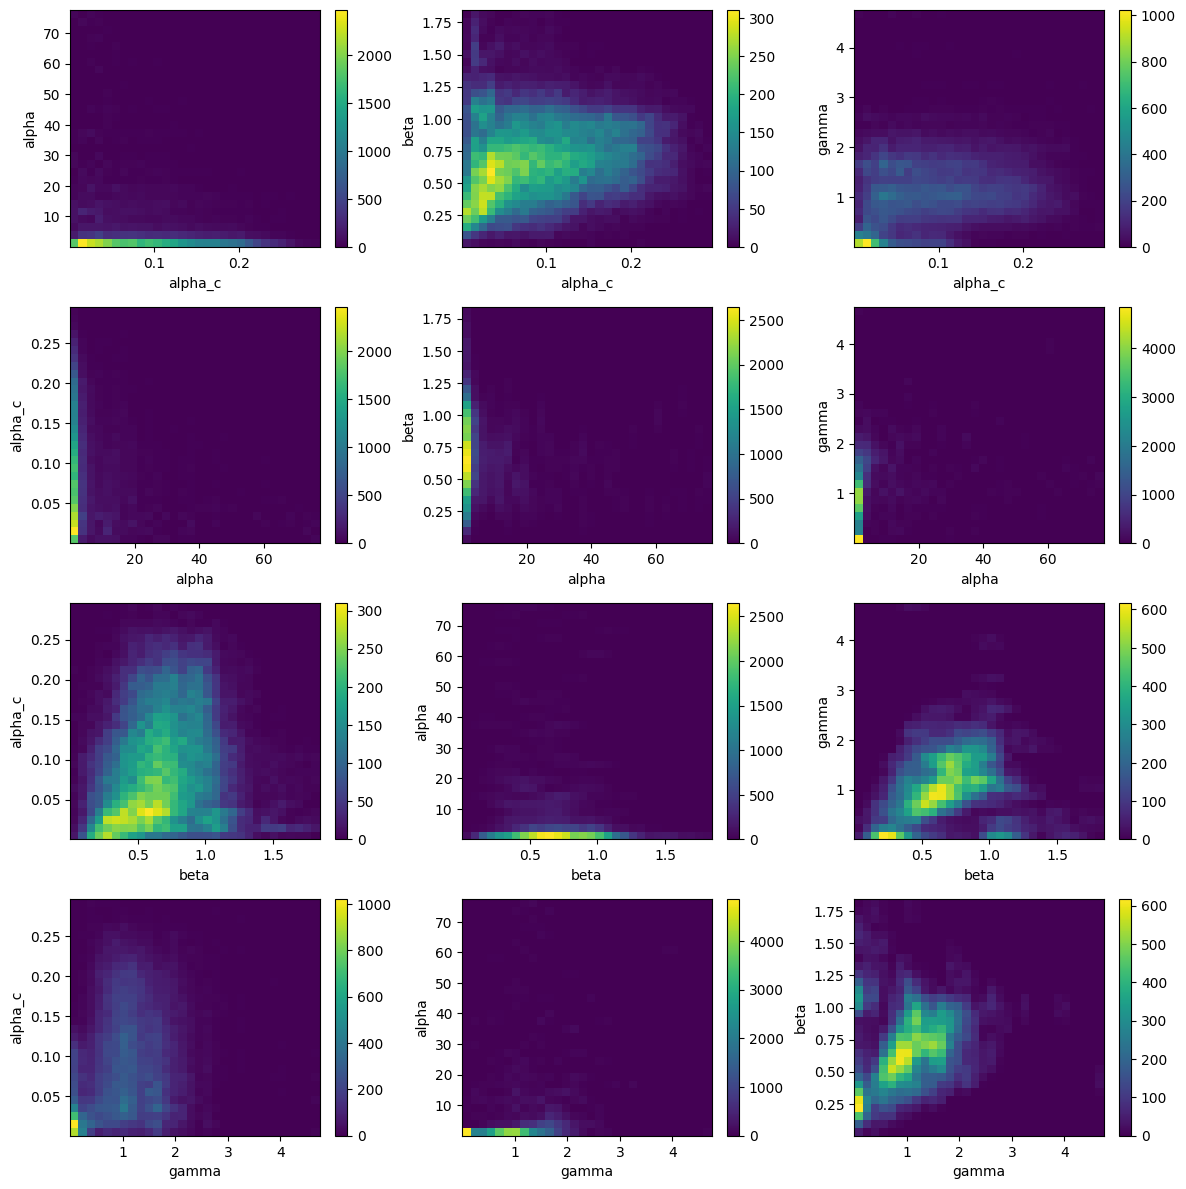

In [15]:
names = ["alpha_c", "alpha", "beta", "gamma"]
fig, axs = plt.subplots(4, 3, figsize=(12, 12))

for i in range(mvln.shape[1]):
    col = 0
    for j in range(mvln.shape[1]):
        
        if i == j:
            continue
        h = axs[i][col].hist2d(np.ravel(mvln[:,i]), np.ravel(mvln[:,j]), bins=30)
        axs[i][col].set_xlabel(names[i])
        axs[i][col].set_ylabel(names[j])
        fig.colorbar(h[3], ax=axs[i][col])
        col += 1

# fig.colorbar(axs)
fig.tight_layout()

## Generate Time Data

In [16]:
# "true time" used for graphing later
# TODO: (Is it?)
true_time = np.linspace(0, 20, n)

In [17]:
# Generate switch time values

np.random.seed(0)
t_sw_array_array = np.empty((n_gene, 3))
for i in range(n_gene):

    # generate 4 intervals drawn from equally wide distributions
    interval1 = np.random.choice(list(range(1,10)))
    interval2 = np.random.choice(list(range(1,10)))
    interval3 = np.random.choice(list(range(1,10)))
    interval4 = np.random.choice(list(range(1,10)))

    # scale the intervals so that the time total is equal to 20
    total = interval1 + interval2 + interval3 + interval4
    scale = 20 / total
    interval1 *= scale
    interval2 *= scale
    interval3 *= scale
    interval4 *= scale

    # calculate the switch times from those intervals
    t_sw_array = np.array([interval1, interval1+interval2, interval1+interval2+interval3])
    t_sw_array_array[i,:] = t_sw_array
        
t_sw_array_array

array([[ 8.        ,  9.33333333, 14.66666667],
       [ 7.61904762, 11.42857143, 17.14285714],
       [ 3.44827586,  8.96551724, 13.79310345],
       ...,
       [ 6.31578947,  8.42105263, 10.52631579],
       [ 8.18181818, 10.90909091, 18.18181818],
       [ 5.71428571, 11.42857143, 14.28571429]])

In [18]:
sw_name = save_folder + "/raw_switch_times.txt"

np.savetxt(sw_name, t_sw_array_array)

In [19]:
model_list = np.random.choice(models, size=n_gene)
np.sum(model_list==1)

52915

In [20]:
model_name = save_folder + "/model_list.txt"

np.savetxt(model_name, model_list)

In [21]:
alpha_c = []
alpha = []
beta = []
gamma = []
output_time = []
tau_matrix = []
c0_matrix = []
u0_matrix = []
s0_matrix = []

In [22]:
adj_switch_times = []
raw_switch_times = []

## Calculate c/u/s values

In [23]:
# np.random.seed(0)
cus_list, cus_sw_list, cus_ss_list, noise_list, para_list = [], [], [], [], []
var_sim_c, var_sim_u, var_sim_s = [], [], []
mean_sim_c, mean_sim_u, mean_sim_s = [], [], []

# make calculations per gene
for i in range(n_gene):

    # get the model, rate parameters, and switch times for each gene
    mod = model_list[i]
    para = mvln[i,:]
    sw = t_sw_array_array[i]
    # dire = direction_list[i]

    # calculate realignment ratios for different directions of genes
    if dire == 1:
        realign_ratio =  20 / sw[1]
        t_min = 0
        t_max = sw[1]
    elif dire == 2:
        realign_ratio = 20 / (20-sw[1])
        t_min = sw[1]
        t_max = 20
    else:
        realign_ratio = 1
        t_min = 0
        t_max = 20

    # if this is a complete gene, then we want to generate an even number of time values from 0 to 20
    if dire == 0:
        t_ = np.random.uniform(low=0.0, high=20, size=n)

    # if this is an induction or repression gene, we want n cells on either side of the second switch time,
    # because we're going to cut off all the data on one side of t_sw_1 (which side depends on whether it's
    # an induction or a repression gene)
    elif dire == 1 or 2:
        t_ = np.concatenate((np.random.uniform(low=0.0, high=sw[1], size=n), np.random.uniform(low=sw[1], high=20, size=n)))

    # sort out the random time points so they're in order
    t_ = np.sort(t_)
    
    # calculate the tau values for each state
    tau1 = t_[t_<=sw[0]]
    tau2 = t_[(sw[0]<t_) & (t_<=sw[1])] - sw[0]
    tau3 = t_[(sw[1]<t_) & (t_<=sw[2])] - sw[1]
    tau4 = t_[sw[2]<t_] - sw[2]
    
    tau_list = [tau1, tau2, tau3, tau4]
    
    tau_matrix.append(tau_list)

    # convert the tau values to a Numba list
    typed_tau_list = List()
    [typed_tau_list.append(x) for x in tau_list]

    # calculate c/u/s values from our tau values and rate parameters
    exp_list, exp_sw_list = generate_exp(typed_tau_list, sw, para[0], para[1], para[2], para[3], model=mod)
    
    cus_sw_list.append(exp_sw_list)
    exp_ss_list = compute_ss_exp(para[0], para[1], para[2], para[3], model=mod)
    cus_ss_list.append(exp_ss_list)

    # assemble the c/u/s points at the beginning of each state
    c0 = [exp_list[0][0,0], exp_sw_list[0][0,0], exp_sw_list[1][0,0], exp_sw_list[2][0,0]]
    u0 = [exp_list[0][0,1], exp_sw_list[0][0,1], exp_sw_list[1][0,1], exp_sw_list[2][0,1]]
    s0 = [exp_list[0][0,2], exp_sw_list[0][0,2], exp_sw_list[1][0,2], exp_sw_list[2][0,2]]

    c0_matrix.append(c0)
    u0_matrix.append(u0)
    s0_matrix.append(s0)

    # choose which states to include in the data depending on which direction this gene is
    if dire == 0:
        all_c = np.concatenate([exp_list[x][:,0] for x in range(4)])
        all_u = np.concatenate([exp_list[x][:,1] for x in range(4)])
        all_s = np.concatenate([exp_list[x][:,2] for x in range(4)])
    if dire == 1:
        all_c = np.concatenate([exp_list[x][:,0] for x in [0,1]])
        all_u = np.concatenate([exp_list[x][:,1] for x in [0,1]])
        all_s = np.concatenate([exp_list[x][:,2] for x in [0,1]])
        t_ = t_[:n]
    elif dire == 2:
        all_c = np.concatenate([exp_list[x][:,0] for x in [2,3]])
        all_u = np.concatenate([exp_list[x][:,1] for x in [2,3]])
        all_s = np.concatenate([exp_list[x][:,2] for x in [2,3]])
        t_ = t_[len(t_)-n:]

    # If this isn't a complete gene, we realign the time data such that
    # the time points fall in the [0, 20] range.
    # We also scale the rate parameters accordingly
    para /= realign_ratio
    new_sw = (sw - t_min) * realign_ratio
    t_ = (t_ - t_min) * realign_ratio

    # check for errors
    if len(all_c) != n:
        raise ValueError(f'final data size is not {n}')
    
    if len(t_) != n:
        print("dire:", dire)
        raise ValueError(f'final t size is not {n}, it is {len(t_)}')

    # collect time and parameter data
    adj_switch_times.append(new_sw)
    output_time.append(t_)
    alpha_c.append(para[0])
    alpha.append(para[1])
    beta.append(para[2])
    gamma.append(para[3])

    # make some approximate variance values for c/u/s
    vc, vu, vs = np.mean(all_c)**2/10, np.max(all_u)**2/600, np.max(all_s)**2/1200 # variance of chromatin set to 2/10 for eq, 2/2 for high-var and 2/50 for low-var
    var_sim_c.append(vc)
    var_sim_u.append(vu)
    var_sim_s.append(vs)
    
    # add simulated noise to c/u/s data
    noise_c = np.random.normal(0, np.sqrt(vc)*factor, n)
    noise_u = np.random.normal(0, np.sqrt(vu)*factor, n)
    noise_s = np.random.normal(0, np.sqrt(vs)*factor, n)

    # collect raw c/u/s data (no noise)
    cus_list.append(np.hstack((np.reshape(all_c,(-1,1)), np.reshape(all_u,(-1,1)), np.reshape(all_s,(-1,1)))))

    # add noice to c/u/s data and collect it
    c_noise = all_c + noise_c
    c_noise[c_noise < 0] = 0
    u_noise = all_u + noise_u
    u_noise[u_noise < 0] = 0
    s_noise = all_s + noise_s
    s_noise[s_noise < 0] = 0
    noise_list.append(np.hstack((np.reshape(c_noise,(-1,1)), np.reshape(u_noise,(-1,1)), np.reshape(s_noise,(-1,1)))))
    mean_sim_c.append(np.mean(c_noise))
    mean_sim_u.append(np.mean(u_noise))
    mean_sim_s.append(np.mean(s_noise))
    para_list.append(para)

var_sim_c, var_sim_u, var_sim_s = np.array(var_sim_c), np.array(var_sim_u), np.array(var_sim_s)
mean_sim_c, mean_sim_u, mean_sim_s = np.array(mean_sim_c), np.array(mean_sim_u), np.array(mean_sim_s)

## Save Simulated Data

In [24]:
alpha_c_name = save_folder + "/alpha_c.txt"
alpha_name = save_folder + "/alpha.txt"
beta_name = save_folder + "/beta.txt"
gamma_name = save_folder + "/gamma.txt"

np.savetxt(alpha_c_name, alpha_c)
np.savetxt(alpha_name, alpha)
np.savetxt(beta_name, beta)
np.savetxt(gamma_name, gamma)

In [25]:
adj_switch_times = np.array(adj_switch_times)

In [26]:
sw_name = save_folder + "/switch_times.txt"

np.savetxt(sw_name, adj_switch_times)

In [27]:
s0_matrix = np.array(s0_matrix)
u0_matrix = np.array(u0_matrix)
c0_matrix = np.array(c0_matrix)

print(s0_matrix.shape)
print(u0_matrix.shape)
print(c0_matrix.shape)

s0_name = save_folder + "/s0_data.txt"
u0_name = save_folder + "/u0_data.txt"
c0_name = save_folder + "/c0_data.txt"

np.savetxt(s0_name, s0_matrix)
np.savetxt(u0_name, u0_matrix)
np.savetxt(c0_name, c0_matrix)

(52915, 4)
(52915, 4)
(52915, 4)


In [28]:
output_time = np.array(output_time)

print(output_time.shape)

output_time = output_time.T

print(output_time.shape)

time_name = save_folder + "/true_time.txt"

np.savetxt(time_name, output_time)

(52915, 750)
(750, 52915)


In [29]:
# c/u/s
save_c = np.array(noise_list)[:,:,0]
save_u = np.array(noise_list)[:,:,1]
save_s = np.array(noise_list)[:,:,2]

print(save_c.shape)

c_name = save_folder + "/save_c.txt"
u_name = save_folder + "/save_u.txt"
s_name = save_folder + "/save_s.txt"

np.savetxt(c_name, save_c)
np.savetxt(u_name, save_u)
np.savetxt(s_name, save_s)

(52915, 750)


In [30]:
raise Exception("Done generating data")

Exception: Done generating data

## Graph Simulated Data

In [ ]:
graph_genes = 500

if graph_genes > n_gene:
    graph_genes = n_gene

fig, axs = plt.subplots(-(-graph_genes // 5), 5, figsize=(14, 2.5 * (-(-graph_genes // 5))), facecolor='white')
fig.patch.set_facecolor('white')
marker_type = ['o', 'X', 'D', '*']
for i in range(graph_genes):
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    t = (output_time.T)[i]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(t, c, s=5)
    # only one line may be specified; full height
    #print(t_sw_array_array[i])
    # for line in t_sw_array_array[i]:
    for line in adj_switch_times[i]:
        axs[row, col].axvline(x = line, color = 'r')
    #for j, sw_exp in enumerate(cus_sw_list[i]):
    #    axs[row, col].plot([output_time.T)], [sw_exp[0,0]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(t[-1], c[-1], marker_type[3]+'r', markersize=8)
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel('c')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])} D{dire}')
fig.tight_layout()

In [ ]:
graph_genes = 500

if graph_genes > n_gene:
    graph_genes = n_gene

fig, axs = plt.subplots(-(-graph_genes // 5), 5, figsize=(14, 2.5 * (-(-graph_genes // 5))), facecolor='white')
fig.patch.set_facecolor('white')
marker_type = ['o', 'X', 'D', '*']
for i in range(graph_genes):
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    t = (output_time.T)[i]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(t, u, s=5)
    # only one line may be specified; full height
    #print(t_sw_array_array[i])
    #for line in t_sw_array_array[i]:
    for line in adj_switch_times[i]:
        axs[row, col].axvline(x = line, color = 'r')
    #for j, sw_exp in enumerate(cus_sw_list[i]):
    #    axs[row, col].plot([output_time.T)], [sw_exp[0,0]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(t[-1], u[-1], marker_type[3]+'r', markersize=8)
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel('u')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])} D{dire}')
fig.tight_layout()

In [ ]:
graph_genes = 500

if graph_genes > n_gene:
    graph_genes = n_gene

fig, axs = plt.subplots(-(-graph_genes // 5), 5, figsize=(14, 2.5 * (-(-graph_genes // 5))), facecolor='white')
fig.patch.set_facecolor('white')
marker_type = ['o', 'X', 'D', '*']
for i in range(graph_genes):
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    t = (output_time.T)[i]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(t, s, s=5)
    # only one line may be specified; full height
    #print(t_sw_array_array[i])
    # for line in t_sw_array_array[i]:
    for line in adj_switch_times[i]:
        axs[row, col].axvline(x = line, color = 'r')
    #for j, sw_exp in enumerate(cus_sw_list[i]):
    #    axs[row, col].plot([output_time.T)], [sw_exp[0,0]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(t[-1], s[-1], marker_type[3]+'r', markersize=8)
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel('s')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])} D{dire}')
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(-(-50 // 5), 5, figsize=(14, 2.5 * (-(-50 // 5))), facecolor='white')
fig.patch.set_facecolor('white')
marker_type = ['o', 'X', 'D', '*']
for i in range(50):
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(u, c, s=5)
    for j, sw_exp in enumerate(cus_sw_list[i]):
        axs[row, col].plot([sw_exp[0,1]], [sw_exp[0,0]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(u[-1], c[-1], marker_type[3]+'r', markersize=8)
    axs[row, col].set_xlabel('u')
    axs[row, col].set_ylabel('c')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])} D{dire}')
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(-(-50 // 5), 5, figsize=(14, 2.5 * (-(-50 // 5))), facecolor='white')
fig.patch.set_facecolor('white')
marker_type = ['o', 'X', 'D', '*']
for i in range(50):
    #axs[row, col].set_title(f'S{i} M{int(model_list[i])} D{dire}')
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(s, u, s=5)
    for j, sw_exp in enumerate(cus_sw_list[i]):
        axs[row, col].plot([sw_exp[0,2]], [sw_exp[0,1]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(s[-1], u[-1], marker_type[3]+'r', markersize=8)
    axs[row, col].set_xlabel('s')
    axs[row, col].set_ylabel('u')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])}')
    # axs[row, col].set_title(f'{para_list[i][0]:.2f}, {para_list[i][1]:.2f}, {para_list[i][2]:.2f}, {para_list[i][3]:.2f}, {t_sw_array_array[i][0]:.1f}')
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(-(-50 // 5), 5, figsize=(14, 2.5 * (-(-50 // 5))))
marker_type = ['o', 'X', 'D', '*']
for i in range(50):
    c = noise_list[i][:,0]
    u = noise_list[i][:,1]
    s = noise_list[i][:,2]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(u, c, s=5)
    for j, sw_exp in enumerate(cus_sw_list[i]):
        axs[row, col].plot([sw_exp[0,1]], [sw_exp[0,0]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(u[-1], c[-1], marker_type[3]+'r', markersize=8)
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    axs[row, col].scatter(u, c, s=2, c='red', alpha=0.3)
    axs[row, col].set_xlabel('u_noise')
    axs[row, col].set_ylabel('c_noise')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])}')
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(-(-50 // 5), 5, figsize=(14, 2.5 * (-(-50 // 5))))
marker_type = ['o', 'X', 'D', '*']
for i in range(50):
    c = noise_list[i][:,0]
    u = noise_list[i][:,1]
    s = noise_list[i][:,2]
    row = i // 5
    col = i % 5
    axs[row, col].scatter(s, u, s=5)
    for j, sw_exp in enumerate(cus_sw_list[i]):
        axs[row, col].plot([sw_exp[0,2]], [sw_exp[0,1]], marker_type[j]+'r', markersize=8)
    axs[row, col].plot(s[-1], u[-1], marker_type[3]+'r', markersize=8)
    c = cus_list[i][:,0]
    u = cus_list[i][:,1]
    s = cus_list[i][:,2]
    axs[row, col].scatter(s, u, s=2, c='red', alpha=0.3)
    axs[row, col].set_xlabel('s_noise')
    axs[row, col].set_ylabel('u_noise')
    axs[row, col].set_title(f'S{i} M{int(model_list[i])}')
fig.tight_layout()

In [ ]:
obs_names = [str(i) for i in range(n)]
var_names = [str(i) for i in range(n_gene)]

In [ ]:
X = np.empty((n,n_gene))
unspliced = np.empty((n,n_gene))
spliced = np.empty((n,n_gene))
atac = np.empty((n,n_gene))
for i in range(n_gene):
    X[:,i] = noise_list[i][:,1] + noise_list[i][:,2]
    unspliced[:,i] = noise_list[i][:,1]
    spliced[:,i] = noise_list[i][:,2]
    atac[:,i] = noise_list[i][:,0]

In [ ]:
X.shape

In [ ]:
adata = AnnData(X = X)
adata.obs_names = obs_names
adata.var_names = var_names
adata.layers['unspliced'] = unspliced.copy()
adata.layers['spliced'] = spliced.copy()
adata.obs['true_time'] = true_time / 20

scv.pp.log1p(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.layers['Mu'] = unspliced.copy()
adata.layers['Ms'] = spliced.copy()
adata.var['highly_variable'] = True

In [ ]:
scv.pl.scatter(adata, adata.var_names[:10])

In [ ]:
adata_atac = AnnData(X = atac.copy())
adata_atac.obs_names = obs_names
adata_atac.var_names = var_names

adata_atac.layers['Mc'] = adata_atac.X
adata_atac.obsp['distances'] = adata.obsp['distances']
adata_atac.obsp['connectivities'] = adata.obsp['connectivities']

In [ ]:
scv.tl.umap(adata)

In [ ]:
scv.pl.scatter(adata, color='true_time', color_map='gnuplot', size=80)

In [ ]:
raise Exception("Bro don't run rdc")

In [ ]:
# not normalized

In [ ]:
mv.settings.VERBOSITY = 1
mv.settings.LOG_FILENAME = "simdata_test.txt"

adata_result2 = mv.recover_dynamics_chrom(adata, 
                                       adata_atac, 
                                       max_iter=5, 
                                       init_mode="invert",
                                       plot=False, 
                                       parallel=True,
                                       n_jobs=10,
                                       save_plot=False,
                                       rna_only=False,
                                       fit=True
                                       )

In [ ]:
low_likelihood_genes = adata_result2.var['fit_likelihood'] < 0.1
adata_bad = adata_result2[:, low_likelihood_genes]
print(adata_bad.var['fit_likelihood'])

In [ ]:
gene_list = ["1","4","8","10"]
mv.dynamic_plot(adata_bad, genes=gene_list, color_by="state")

In [ ]:
mv.scatter_plot(adata_bad, by='us', genes=gene_list)
mv.scatter_plot(adata_bad, by='cu', genes=gene_list)

In [ ]:
print("alpha/beta:")
print(adata_bad.var['fit_alpha'] / adata_bad.var['fit_beta'])
print()
print("alpha/gamma:")
print(adata_bad.var['fit_alpha'] / adata_bad.var['fit_gamma'])

In [ ]:
fit_time = np.array(adata_result2.layers["fit_t"])

In [ ]:
print(fit_time.shape)

In [ ]:
np.sum(adata_result2.var['velo_s_genes'])

In [ ]:
if 'root_cells' in adata_result2.obs:
    del adata_result2.obs['root_cells']
velocity_graph(adata_result2)
latent_time(adata_result2)

In [ ]:
adata_result2.obs["true_time"] = true_time

In [ ]:
adata_result2.write("sim_data.h5ad")

In [ ]:
velocity_embedding_stream(adata_result2, basis='umap', color='latent_time', color_map='gnuplot', size=80)

In [ ]:
scv.pl.scatter(adata_result2, color='latent_time', color_map='gnuplot', size=80)

In [ ]:
scv.pl.scatter(adata_result2, color=['root_cells'])

In [ ]:
scv.pl.scatter(adata_result2, color=adata_result2.obs['latent_time'] - adata_result2.obs['true_time'], color_map='gnuplot', size=80)

In [ ]:
velocity_embedding_stream(adata_result2, basis='umap', color='true_time', color_map='gnuplot', size=80)

In [ ]:
scv.pl.scatter(adata_result2, color=np.var(adata_result2.layers['fit_t']/20, axis=1))

In [ ]:
scatter_plot(adata_result2, adata_result2.var_names[:100], by='us', color_by='c', axis_on=False, frame_on=False, title_more_info=True)

In [ ]:
model_pred = adata_result2.var['fit_model'].values
dire_pred = []
directions = adata_result2.var['fit_direction'].values
for i in range(n_gene):
    if directions[i] == 'complete':
        dire_pred.append(0)
    elif directions[i] == 'on':
        dire_pred.append(1)
    else:
        dire_pred.append(2)
dire_pred = np.array(dire_pred)
filt = (dire == 0) & (dire_pred == 0)
np.sum(filt)

In [ ]:
pie_summary(adata_result2)

In [ ]:
np.sum(model_list[filt] == model_pred[filt])

In [ ]:
np.sum(dire == dire_pred)

In [ ]:
adata_result2

In [ ]:
print(len(adata_result2.var['fit_likelihood']))
print(max(adata_result2.var['fit_likelihood']))
print(min(adata_result2.var['fit_likelihood']))

In [ ]:
plt.hist(adata_result2.var['fit_likelihood'], bins=100)

In [ ]:
adata_result = sc.read_h5ad('../10x_mouse_brain/multivelo.h5ad')

In [ ]:
adata_result

In [ ]:
n_anchors = adata_result.uns['velo_s_params']['t']
var_c = np.empty(adata_result.n_vars)
var_u = np.empty(adata_result.n_vars)
var_s = np.empty(adata_result.n_vars)
mean_c = np.empty(adata_result.n_vars)
mean_u = np.empty(adata_result.n_vars)
mean_s = np.empty(adata_result.n_vars)
i = 0
for gene in adata_result.var_names:
    c_all = np.ravel(adata_result[:,gene].layers['ATAC'])
    u_all = np.ravel(adata_result[:,gene].layers['Mu'])
    s_all = np.ravel(adata_result[:,gene].layers['Ms'])
    
    non_zero = (c_all > 0.1 * np.max(c_all)) & (u_all > 0.1 * np.max(u_all)) & (s_all > 0.1 * np.max(s_all))
    t = np.ravel(adata_result[:,gene].layers['fit_t'])[:,None]
    c_all, u_all, s_all, t = c_all[non_zero], u_all[non_zero], s_all[non_zero], t[non_zero]
    
    min_idx = int(adata_result[:,gene].var['fit_anchor_min_idx'])
    max_idx = int(adata_result[:,gene].var['fit_anchor_max_idx'])
    a_c = adata_result[:,gene].varm['fit_anchor_c'].ravel()[min_idx:max_idx+2].copy()
    a_u = adata_result[:,gene].varm['fit_anchor_u'].ravel()[min_idx:max_idx+2].copy()
    a_s = adata_result[:,gene].varm['fit_anchor_s'].ravel()[min_idx:max_idx+2].copy()
    old_t = np.linspace(0, 20, n_anchors)[min_idx:max_idx+2]
    new_t = old_t - np.min(old_t)
    new_t = new_t * 20 / np.max(new_t)
    
    anchor_idx = np.isclose(t - new_t, 0, atol=1e-4)
    anchor_idx = np.argwhere(anchor_idx)
    if anchor_idx.shape[0] != np.sum(non_zero):
        a_c = adata_result[:,gene].varm['fit_anchor_c'].ravel()[min_idx:max_idx+1].copy()
        a_u = adata_result[:,gene].varm['fit_anchor_u'].ravel()[min_idx:max_idx+1].copy()
        a_s = adata_result[:,gene].varm['fit_anchor_s'].ravel()[min_idx:max_idx+1].copy()
        old_t = np.linspace(0, 20, n_anchors)[min_idx:max_idx+1]
        new_t = old_t - np.min(old_t)
        new_t = new_t * 20 / np.max(new_t)

        anchor_idx = np.isclose(t - new_t, 0, atol=1e-4)
        anchor_idx = np.argwhere(anchor_idx)
        if anchor_idx.shape[0] != np.sum(non_zero):
            print(gene, anchor_idx.shape[0], np.sum(non_zero))
            print(np.sort(np.unique(np.ravel(t))))
            print(new_t)
            break
    anchor_idx = anchor_idx[:,1]
    a_c_ = a_c[anchor_idx]
    a_u_ = a_u[anchor_idx]
    a_s_ = a_s[anchor_idx]
    
    var_c[i] = np.var((c_all - a_c_) / np.max(c_all))
    var_u[i] = np.var(u_all - a_u_)
    var_s[i] = np.var(s_all - a_s_)
    mean_c[i] = np.mean(c_all / np.max(c_all))
    mean_u[i] = np.mean(u_all)
    mean_s[i] = np.mean(s_all)
    i += 1

In [ ]:
plt.hist(np.log(mean_c), bins=100, alpha=0.5);
plt.hist(np.log(mean_sim_c), bins=100, alpha=0.5);

In [ ]:
plt.hist(np.log(mean_u), bins=100, alpha=0.5);
plt.hist(np.log(mean_sim_u), bins=100, alpha=0.5);

In [ ]:
plt.hist(np.log(mean_s), bins=100, alpha=0.5);
plt.hist(np.log(mean_sim_s), bins=100, alpha=0.5);

In [ ]:
plt.hist(np.log(var_c / mean_c), bins=100, alpha=0.5);
plt.hist(np.log(var_sim_c / mean_sim_c), bins=100, alpha=0.5);

In [ ]:
plt.hist(np.log(var_u / mean_u), bins=100, alpha=0.5);
plt.hist(np.log(var_sim_u / mean_sim_u), bins=100, alpha=0.5);

In [ ]:
plt.hist(np.log(var_s / mean_s), bins=100, alpha=0.5);
plt.hist(np.log(var_sim_s / mean_sim_s), bins=100, alpha=0.5);

In [ ]:
del adata_result

In [ ]:
a = adata_result2.obs['latent_time'] - adata_result2.obs['true_time']
b = np.var(adata_result2.layers['fit_t']/20, axis=1)
df = pd.DataFrame({'diff':a, 'var':b})
df.to_csv('sim_4-5-1.txt', sep='\t', index=False)

In [ ]:
# scvelo

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=12)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [ ]:
a = adata.obs['latent_time'] - adata.obs['true_time']
b = np.var(adata.layers['fit_t']/20, axis=1)
df = pd.DataFrame({'diff':a, 'var':b})
df.to_csv('sim_4-5-1_scvelo.txt', sep='\t', index=False)

In [ ]:
scv.pl.scatter(adata, color=adata.obs['latent_time'] - adata.obs['true_time'], color_map='gnuplot', size=80)

In [ ]:
scv.pl.scatter(adata, color=np.var(adata.layers['fit_t']/20, axis=1))

In [ ]:
plt.hist(np.ravel(adata.layers['fit_t']), bins=50);

In [ ]:
scv.pl.scatter(adata, adata.var_names[:20], ncols=10)

In [ ]:
scv.pl.scatter(adata, adata.var_names[20:40], ncols=10)

In [ ]:
sns.set(font_scale=1.4)

In [ ]:
a = pd.read_csv('sim_4-5-1.txt', sep='\t')
b = pd.read_csv('sim_4-4-2.txt', sep='\t')
c = pd.read_csv('sim_4-3-3.txt', sep='\t')
d = pd.read_csv('sim_6-3-1.txt', sep='\t')
e = pd.read_csv('sim_1-8-1.txt', sep='\t')
f = pd.read_csv('sim_4-5-1_low_var.txt', sep='\t')
g = pd.read_csv('sim_4-5-1_high_var.txt', sep='\t')

h = pd.read_csv('sim_4-5-1_scvelo.txt', sep='\t')
i = pd.read_csv('sim_4-4-2_scvelo.txt', sep='\t')
j = pd.read_csv('sim_4-3-3_scvelo.txt', sep='\t')
k = pd.read_csv('sim_6-3-1_scvelo.txt', sep='\t')
l = pd.read_csv('sim_1-8-1_scvelo.txt', sep='\t')
m = pd.read_csv('sim_4-5-1_low_var_scvelo.txt', sep='\t')
n = pd.read_csv('sim_4-5-1_high_var_scvelo.txt', sep='\t')

In [ ]:
df1 = pd.DataFrame({'4:5:1':a['diff'].to_numpy(), 
                    '4:4:2':b['diff'].to_numpy(), 
                    '4:3:3':c['diff'].to_numpy(), 
                    '6:3:1':d['diff'].to_numpy(), 
                    '1:8:1':e['diff'].to_numpy(), 
                    '4:5:1 LV':f['diff'].to_numpy(), 
                    '4:5:1 HV':g['diff'].to_numpy(),
                    '4:5:1 scv':h['diff'].to_numpy(), 
                    '4:4:2 scv':i['diff'].to_numpy(), 
                    '4:3:3 scv':j['diff'].to_numpy(), 
                    '6:3:1 scv':k['diff'].to_numpy(), 
                    '1:8:1 scv':l['diff'].to_numpy(), 
                    '4:5:1 LV scv':m['diff'].to_numpy(), 
                    '4:5:1 HV scv':n['diff'].to_numpy()
                   })

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24,8))
sns.violinplot(data=df1, ax=ax);
ax.set_title('Difference Between Latent Time and True Time');

In [ ]:
df2 = pd.DataFrame({'4:5:1':a['var'].to_numpy(), 
                    '4:4:2':b['var'].to_numpy(), 
                    '4:3:3':c['var'].to_numpy(), 
                    '6:3:1':d['var'].to_numpy(), 
                    '1:8:1':e['var'].to_numpy(), 
                    '4:5:1 LV':f['var'].to_numpy(), 
                    '4:5:1 HV':g['var'].to_numpy(),
                    '4:5:1 scv':h['var'].to_numpy(), 
                    '4:4:2 scv':i['var'].to_numpy(), 
                    '4:3:3 scv':j['var'].to_numpy(), 
                    '6:3:1 scv':k['var'].to_numpy(), 
                    '1:8:1 scv':l['var'].to_numpy(), 
                    '4:5:1 LV scv':m['var'].to_numpy(), 
                    '4:5:1 HV scv':n['var'].to_numpy()
                   })

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize=(24,8))
sns.violinplot(data=df2, ax=ax2);
ax2.set_title('Variance of Fit Time Across Genes');